# **IMPLEMENT CNN for Facial Emotion Recognition**


```
Christos Koromilas(i6345703) & Spyridon Giagtzoglou (i6329021)
```



# Notebook Setup and Library Import

In [ ]:
# Standard libraries
import os
import cv2
import csv
import glob
import json
import math
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Google Colab libraries
from google.colab import drive, files
from google.colab.patches import cv2_imshow

# Tensorflow and Keras libraries
import tensorflow as tf
from tensorflow.keras import optimizers, callbacks, preprocessing, regularizers
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import (Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
                                     Dropout, BatchNormalization, LeakyReLU, Activation)
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam

# Visual Keras
!pip install -q visualkeras
import visualkeras

# Sklearn libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Moviepy
!pip install -q moviepy
from moviepy.editor import VideoFileClip, vfx

# IPython display and widgets
from IPython.display import Image, display
import ipywidgets as widgets
import tempfile


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 46.3 MB/s eta 0:00:00


# Directory Paths and Mounting Drive (Google_Drive)

The folder in GoogleDrive:
```
https://drive.google.com/drive/folders/18ZFc_B3AOvVNZ1deMIQzOI2_vHZAriQb?usp=sharing
```



Choose your main path:

In [ ]:
drive.mount(
    "/content/drive"
    # , force_remount=True
    )
# Our Directory
main_directory_path = "./drive/MyDrive/Assignment_CV/2/Group_4/"  

# Your Directory
# main_directory_path = "./drive/MyDrive/Group_4/"

Mounted at /content/drive


Directory Paths

In [ ]:
# Set the path to the dataset directory
dataset_path = main_directory_path + "Dataset/"

# Set the path to export plots in images directory
images_path = main_directory_path + "Data/Images/"

# Set the path to the models directory
models_path = main_directory_path + "Data/Models/"

# Set the path to the loss and accuracy directory
loss_accuracy_path = main_directory_path + "Data/Loss_Accuracy/"

# Set the path to the prediction results directory
prediction_results_path = main_directory_path + "Data/Prediction_Results/"

# Set the path to the videos directory
videos_path = main_directory_path + "Data/Videos/"

# Set the path to the hidden layers directory
layers_path = main_directory_path + "Data/Layers_Hidden/"


# Pre-Processing FER2013 Dataset

## **Load FER2013**

Available Datasets

In [ ]:
dataset_ex = ["Submission.csv"]
datasets = [f for f in os.listdir(dataset_path) if f.endswith(".csv") and f not in dataset_ex]
print(datasets)

['fer2013.csv']


Selected Dataset

In [ ]:
dataset = datasets[0]

## **Dataset Loading, Overview, Emotion Classes, and Image Distribution**

Dataset Loading and Overview

In [ ]:
df = pd.read_csv(dataset_path + dataset)
print(df.head())
print("\nShape: ", df.shape)

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

Shape:  (35887, 3)


Unique Emotions Classes

In [ ]:
# All different emotions as classes:
emotions_class = df.emotion.unique()
emotions_class

array([0, 2, 4, 6, 3, 5, 1])

Emotion Classes and Dataset Samples

In [ ]:
# Define each class with the emotion
classes_of_emotions = {
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happiness",
    4: "Sadness",
    5: "Surprise",
    6: "Neutral"
}

images = df.pixels.values
labels = df.emotion.values

print(classes_of_emotions)

{0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}


Distribution of Images per Emotion

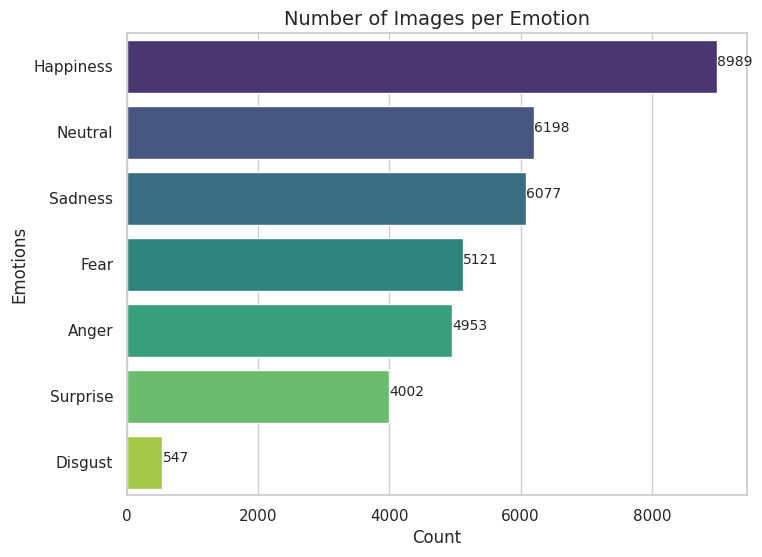

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(y="emotion", data=df, order=df["emotion"].value_counts().index, palette="viridis")

plt.xlabel("Count", fontsize=12)
plt.ylabel("Emotions", fontsize=12)
plt.title("Number of Images per Emotion", fontsize=14)

ax.set_yticklabels([classes_of_emotions[int(label.get_text())] for label in ax.get_yticklabels()])

for p in ax.patches:
    ax.annotate(f'{p.get_width():.0f}', (p.get_width() + 5, p.get_y() + 0.4), fontsize=10)

plt.savefig(images_path + "number_of_images_per_emotions.png")
plt.show()

## **Sample Images for Each Emotion**

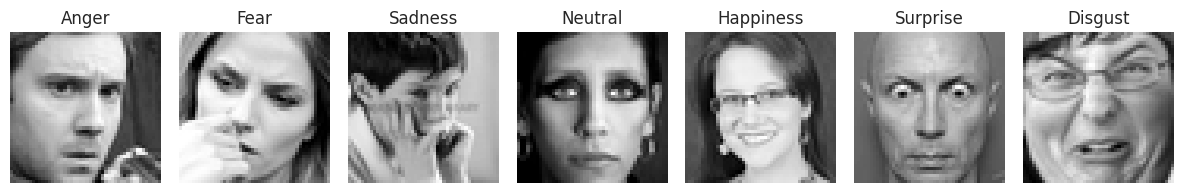

In [ ]:
num_images = len(emotions_class)
fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

for i, emotion in enumerate(emotions_class[:num_images]):
    index = np.where(labels == emotion)[0][0]
    image = images[index]

    image = np.fromstring(image, dtype=int, sep=" ")

    image = image.reshape((48, 48))

    axes[i].imshow(image, cmap="gray")
    axes[i].set_title(classes_of_emotions[emotion])
    axes[i].axis("off")

plt.tight_layout()
plt.savefig(images_path + "FER2013_images_with_emotions.png")
plt.show()

## **Prepare and Split the Dataset for Train-Validation-Test**

Recommended Dataset Split

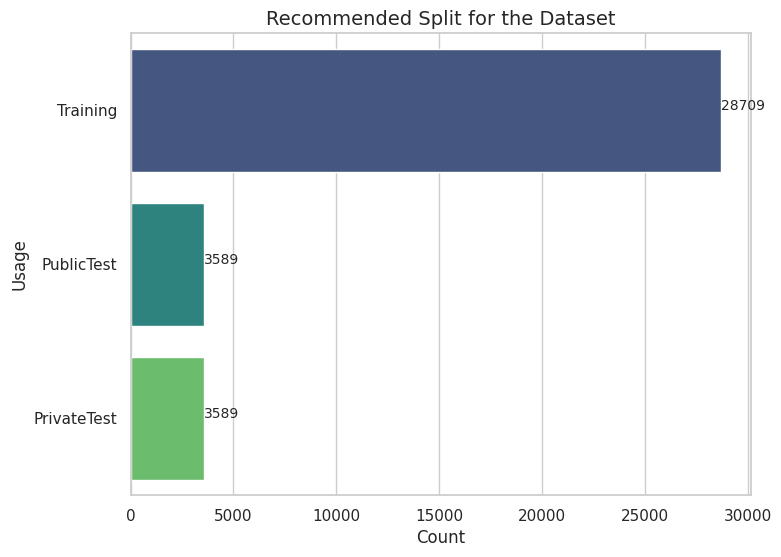

In [ ]:
usage_counts = df["Usage"].value_counts()

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=usage_counts, y=usage_counts.index, palette="viridis")

plt.xlabel("Count", fontsize=12)
plt.ylabel("Usage", fontsize=12)
plt.title("Recommended Split for the Dataset", fontsize=14)

for p in ax.patches:
    ax.annotate(f'{p.get_width():.0f}', (p.get_width() + 5, p.get_y() + 0.4), fontsize=10)

plt.savefig(images_path + "recommended_split.png")
plt.show()

Dataset Split Shapes

In [ ]:
train_data = df[df["Usage"] == "Training"]
public_test_data = df[df["Usage"] == "PublicTest"]
private_test_data = df[df["Usage"] == "PrivateTest"]
print("Shapes:\nTraining: ", train_data.shape,
      "\nPublicTest: ", public_test_data.shape,
      "\nPrivateTest: ", private_test_data.shape
     )


Shapes:
Training:  (28709, 3) 
PublicTest:  (3589, 3) 
PrivateTest:  (3589, 3)


Dataset Split into Train&Validation and Test

In [ ]:
train_images = train_data["pixels"].values
train_labels = train_data["emotion"].values

public_test_images = public_test_data["pixels"].values
public_test_labels = public_test_data["emotion"].values

# private_test_images = private_test_data["pixels"].values
# private_test_labels = private_test_data["emotion"].values


Training&Validation and Test Set:

In [ ]:
X_train_val = np.array([np.fromstring(image, dtype=int, sep=" ") for image in train_images])
X_test = np.array([np.fromstring(image, dtype=int, sep=" ") for image in public_test_images])

# X_private_test = np.array([np.fromstring(image, dtype=int, sep=" ") for image in private_test_images])

y_train_val = train_labels
y_test = public_test_labels

# y_private_test = private_test_labels

One-Hot Encoding of Labels

In [ ]:
y_train_val = to_categorical(y_train_val, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

Normalization of Image Data

In [ ]:
X_train_val = X_train_val/ 255.0
X_test = X_test/ 255.0

Reshaping Image Data

In [ ]:
X_train_val = X_train_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

Train-Validation Split

In [ ]:
# We perform a manual train-validation 
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  shuffle=True, 
                                                  test_size=0.1, 
                                                  stratify=y_train_val
                                                  )

Dataset and Split Dimensions

In [ ]:
print("\nTraining Data Dimensions: ", X_train.shape)
print("\nValidation Data Dimensions: ", X_val.shape)
print("\nTesting Data Dimensions: ", X_test.shape)
print("\nImage Shape: ", str(X_train[0].shape[0]) + " x "+ str(X_train[0].shape[1]))
print("\nShape of trainings set: ", y_train.shape[0])
print("\nValidation Data Dimensions: ", y_val.shape[0])
print("\nShape of test set is: ", y_test.shape[0])


Training Data Dimensions:  (25838, 48, 48, 1)

Validation Data Dimensions:  (2871, 48, 48, 1)

Testing Data Dimensions:  (3589, 48, 48, 1)

Image Shape:  48 x 48

Shape of trainings set:  25838

Validation Data Dimensions:  2871

Shape of test set is:  3589


# Create 4 CNN Models

## **CNN Models for Facial Emotion Recognition**

In [ ]:
kernel_size = (3, 3)
input_shape=(48, 48, 1)
pool_size = (2, 2)

# Simple CNN
def Simpler_FER_CNN():

    model = Sequential()

    model.add(Conv2D(
        filters=32, 
        kernel_size=kernel_size, 
        activation='relu', 
        input_shape=input_shape
        )
    )

    model.add(MaxPooling2D(pool_size=pool_size))

    model.add(Conv2D(
        filters=64, 
        kernel_size=kernel_size, 
        activation='relu'
        )
    )

    model.add(MaxPooling2D(pool_size=pool_size))

    model.add(Flatten(name='flatten'))

    model.add(Dense(128, activation='relu'))

    model.add(Dense(7, activation='softmax'))
    
    return model

# 1st Improve
def FER_CNN():

    model = Sequential()

    model.add(
        Conv2D(
            filters=64,
            kernel_size=kernel_size,
            input_shape=input_shape,
            activation='relu'
        )
    )
    model.add(BatchNormalization())

    model.add(
        Conv2D(
            filters=64,
            kernel_size=kernel_size,
            activation='relu'
        )
    )
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))

    model.add(
        Conv2D(
            filters=128,
            kernel_size=kernel_size,
            activation='relu'
        )
    )
    model.add(BatchNormalization())

    model.add(
        Conv2D(
            filters=128,
            kernel_size=kernel_size,
            activation='relu'
        )
    )
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))

    model.add(
        Conv2D(
            filters=256,
            kernel_size=kernel_size,
            activation='relu'
        )
    )
    model.add(BatchNormalization())

    model.add(
        Conv2D(
            filters=256,
            kernel_size=kernel_size,
            activation='relu'
        )
    )
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))

    model.add(Flatten(name='flatten'))

    model.add(
        Dense(
            512,
            activation='relu'
        )
    )
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(
        Dense(
            256,
            activation='relu'
        )
    )
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(
        Dense(
            7,
            activation='softmax'
        )
    )

    return model

# 2nd Improve
def V2_FER_CNN():

    model = Sequential()

    model.add(
        Conv2D(
            32, 
            kernel_size, 
            padding='same', 
            kernel_initializer='he_normal', 
            input_shape=(48, 48, 1)
        )
    )
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(
        Conv2D(
            32,
             kernel_size,
             padding='same', 
             kernel_initializer='he_normal'
        )
    )
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.2))

    model.add(
        Conv2D(
            64, 
            kernel_size, 
            padding='same', 
            kernel_initializer='he_normal'
        )
    )
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(
        Conv2D(
            64, 
            kernel_size, 
            padding='same', 
            kernel_initializer='he_normal'
        )
    )
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.3))

    model.add(
        Conv2D(
            128, 
            kernel_size, 
            padding='same', 
            kernel_initializer='he_normal'
        )
    )
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(
        Conv2D(
            128, 
            kernel_size, 
            padding='same', 
            kernel_initializer='he_normal'
        )
    )
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.4))

    model.add(Flatten(name='flatten'))

    model.add(
        Dense(
            256, 
            kernel_initializer='he_normal'
        )
    )
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(
        Dense(
            128, 
            kernel_initializer='he_normal'
        )
    )
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

    model.add(
        Dense(
            7, 
            activation='softmax'
        )
    )

    return model

# 3rd Improve with Regularization
def regular_FER_CNN():
    
    model = Sequential()

    model.add(
        Conv2D(
            filters=64,
            kernel_size=kernel_size,
            input_shape=(48, 48, 1),
            activation='relu',
            kernel_regularizer=regularizers.l2(0.001)
        )
    )
    model.add(BatchNormalization())

    model.add(
        Conv2D(
            filters=64,
            kernel_size=kernel_size,
            activation='relu',
            kernel_regularizer=regularizers.l2(0.001)
        )
    )
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))

    model.add(
        Conv2D(
            filters=128,
            kernel_size=kernel_size,
            activation='relu',
            kernel_regularizer=regularizers.l2(0.001)
        )
    )
    model.add(BatchNormalization())

    model.add(
        Conv2D(
            filters=128,
            kernel_size=kernel_size,
            activation='relu',
            kernel_regularizer=regularizers.l2(0.001)
        )
    )
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))

    model.add(
        Conv2D(
            filters=256,
            kernel_size=kernel_size,
            activation='relu',
            kernel_regularizer=regularizers.l2(0.001)
        )
    )
    model.add(BatchNormalization())

    model.add(
        Conv2D(
            filters=256,
            kernel_size=(3, 3),
            activation='relu',
            kernel_regularizer=regularizers.l2(0.001)
        )
    )
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))

    model.add(Flatten(name='flatten'))

    model.add(
        Dense(
            512,
            activation='relu',
            kernel_regularizer=regularizers.l2(0.001)
        )
    )
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(
        Dense(
            256,
            activation='relu',
            kernel_regularizer=regularizers.l2(0.001)
        )
    )
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(
        Dense(
            7,
            activation='softmax'
        )
    )
    return model


##**Define each CNN**

In [ ]:
cnns = [
    Simpler_FER_CNN(),
    FER_CNN(),
    V2_FER_CNN(),
    regular_FER_CNN()
    ]

##**Summary of CNN Models for Facial Emotion Recognition**

In [ ]:
for i, cnn in enumerate(cnns):
    print(f"Model: {i + 1}")
    cnn.summary()
    print("=================================================================")

Model: 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 128)       

In [ ]:
for cnn in cnns:
    print("Number of parameters:", cnn.count_params())
    print("=====================================================")

Number of parameters: 839047
Number of parameters: 1808839
Number of parameters: 1503463
Number of parameters: 1808839


##**Visualize CNN Model Diagrams for Facial Emotion Recognition**

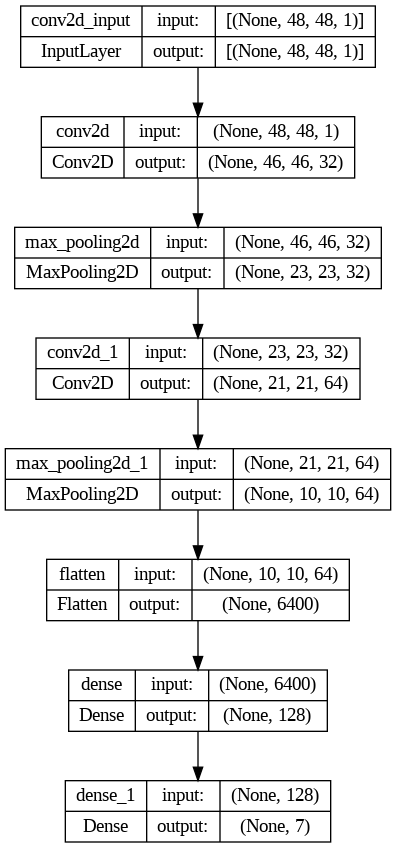

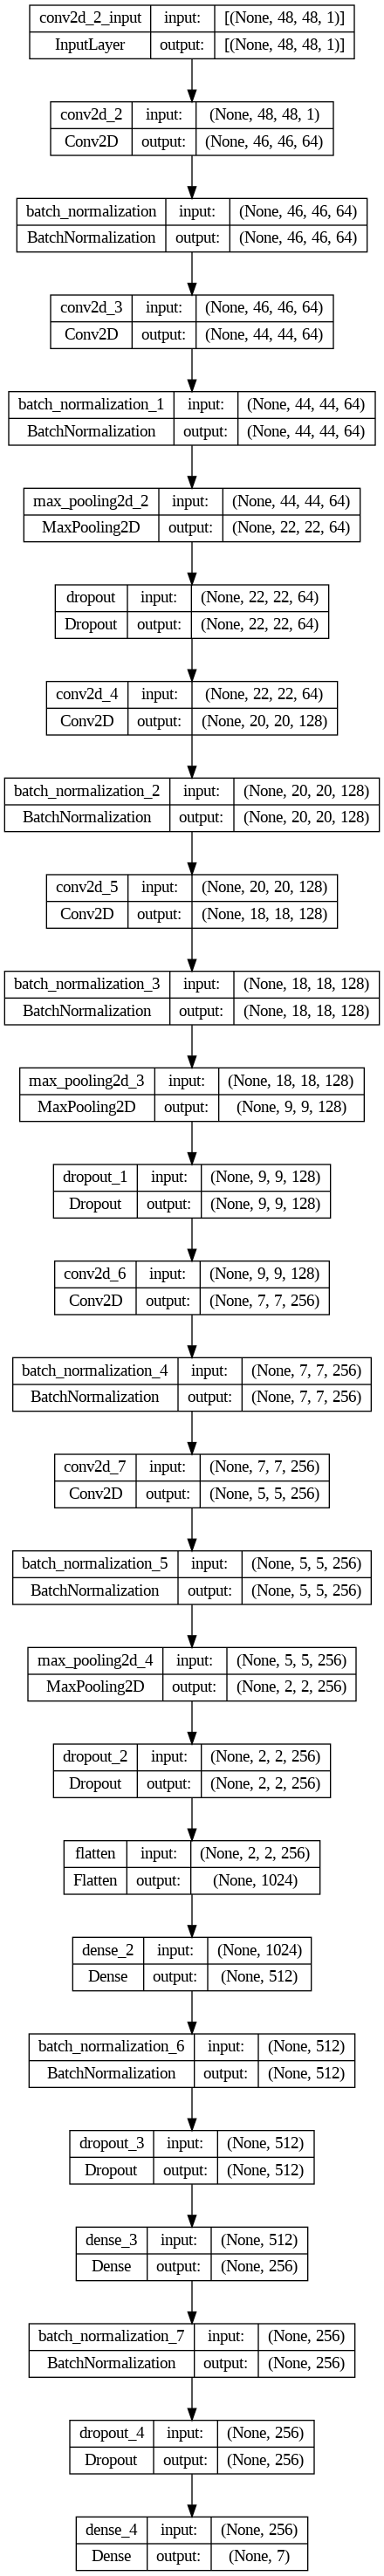

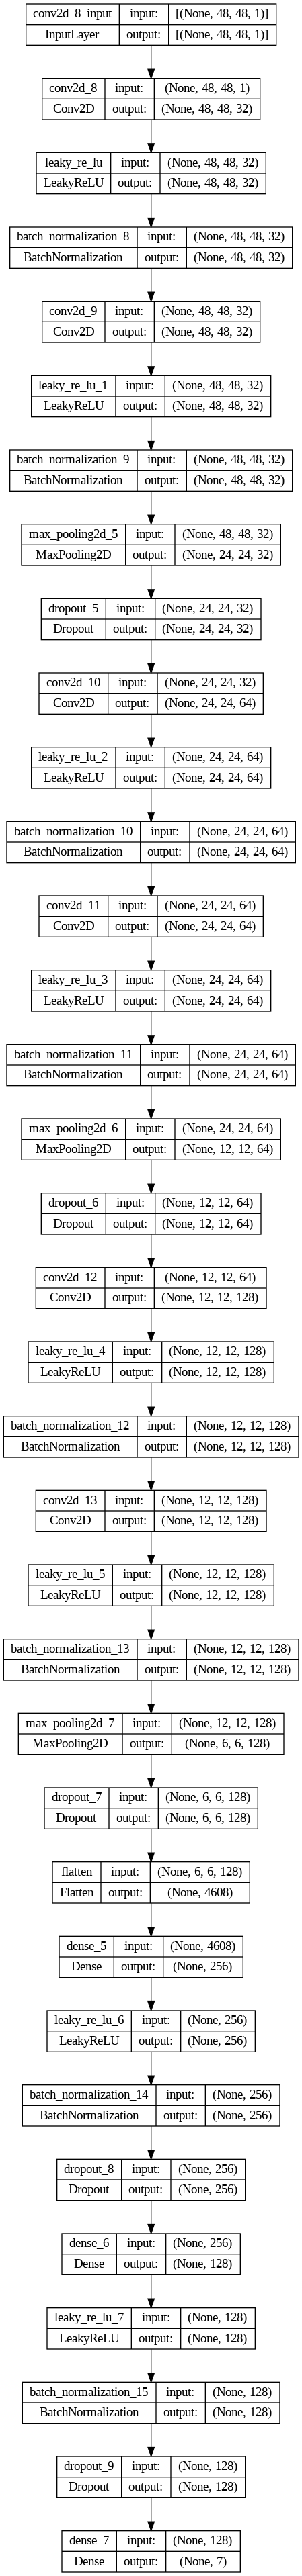

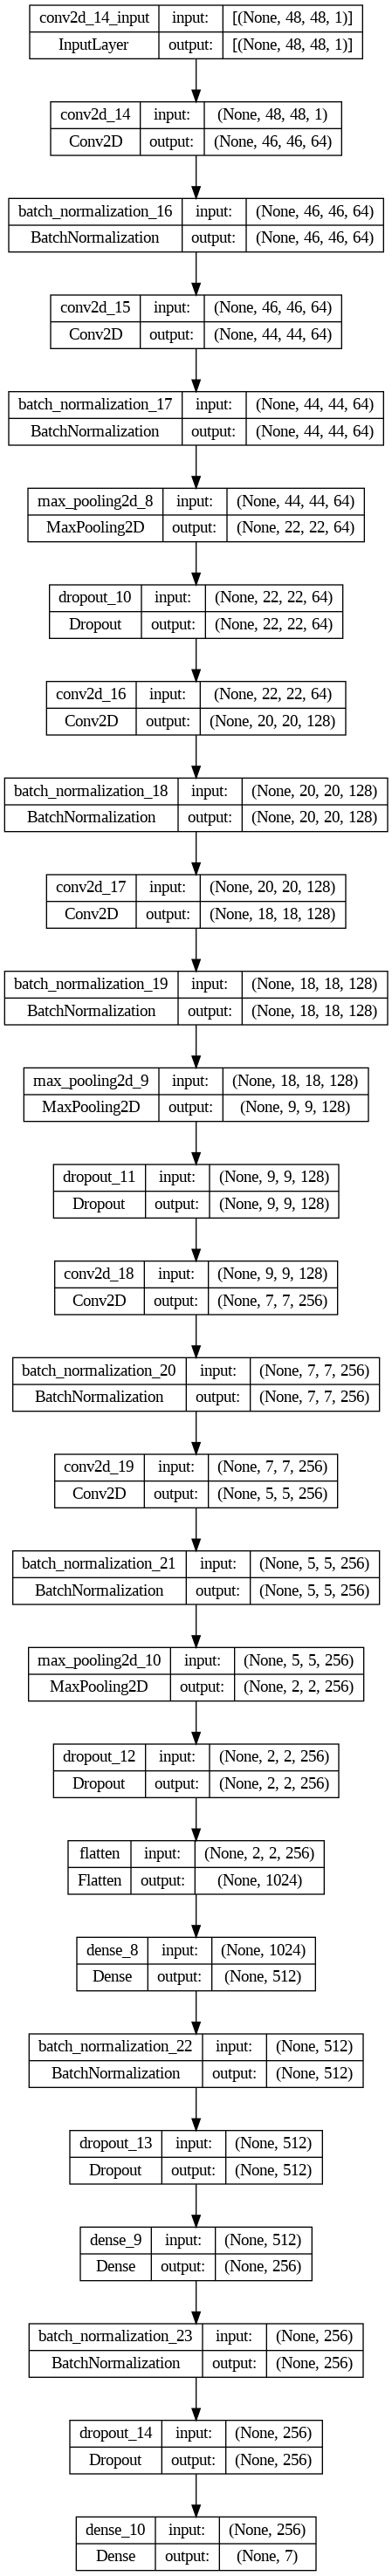

In [ ]:
for i, cnn in enumerate(cnns):
    plot_model(cnn, to_file=models_path + "Diagrams/" + f"model_diagram_{i+1}.png", show_shapes=True, show_layer_names=True)
    display(Image(models_path+ "Diagrams/" + f"model_diagram_{i+1}.png"))


## **3D Visualization of CNN Models for Facial Emotion Recognition**

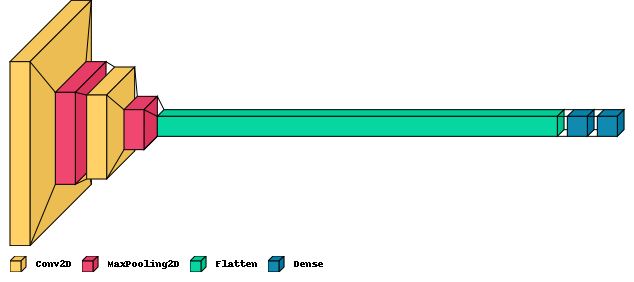

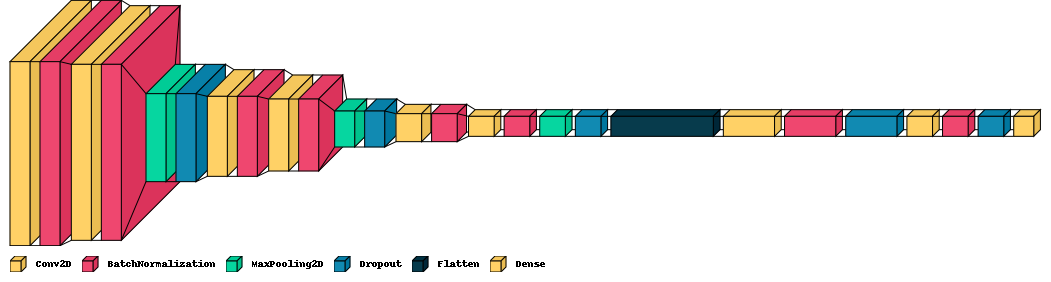

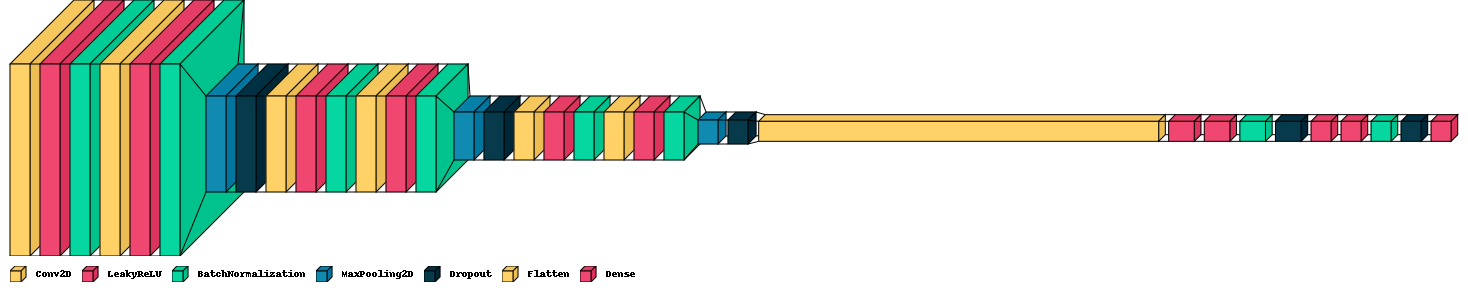

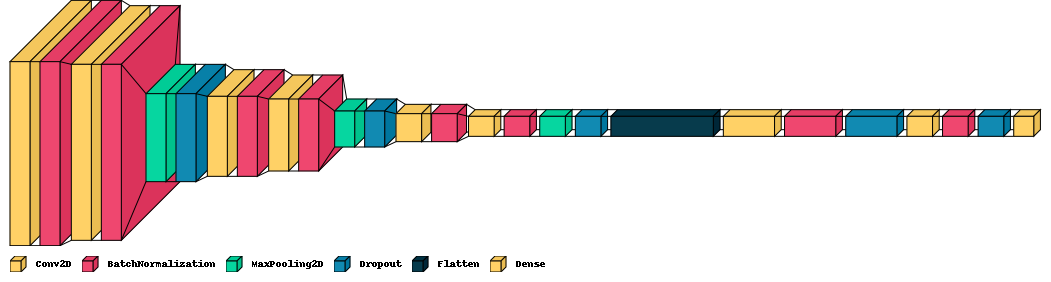

In [ ]:
for i, cnn in enumerate(cnns):
    visualkeras.layered_view(cnn, legend=True).show()
    visualkeras.layered_view(cnn, legend=True).save(models_path + "Diagrams/" + f"3D_model_{i+1}.png")

## **Compilation of CNN Models for Facial Emotion Recognition**
We use crossentropy as a loss function, and the ADAM optimizer to compile CNNs defaults learning rate 0.001

In [ ]:
# from tensorflow.keras.optimizers.schedules import ExponentialDecay
# lr_schedule = ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.9)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

for cnn in cnns:
  cnn.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)


##**Extra for models: Image Augmentation and Early Stopping**


Early Stopping for Model Training

In [ ]:
# We define an early stopping method in case we don't see any improvements in our validation accuracy
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True
)

callbacks = [
    early_stopping
]

 Image Augmentation Techniques for Training Data

In [ ]:
# Image augmentation techniques
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.10,
    horizontal_flip=True,
    # brightness_range=[0.8, 1.2],  # Example for brightness adjustment
    # contrast_range=[0.8, 1.2]     # Example for contrast adjustment
)
gen.fit(X_train)

# Train and save all CNNS

## **Train**

Training Parameters

In [ ]:
batch_size = 32
steps_per_epoch = len(X_train) / 32
epochs = 50

Data Augmentation for Training Data

In [ ]:
train_batches = gen.flow(X_train, y_train, batch_size=batch_size)

Training Multiple CNN Models and Collecting Histories

In [ ]:
histories = []

for cnn in cnns:
  history = cnn.fit(
    train_batches,
    validation_data = (X_val, y_val),
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    callbacks = callbacks,
    use_multiprocessing = True
    )
  histories.append(history)

Epoch 1/50
807/807 [==============================] - 31s 38ms/step - loss: 1.7766 - accuracy: 0.2687 - val_loss: 1.7289 - val_accuracy: 0.2881
Epoch 2/50
807/807 [==============================] - 25s 30ms/step - loss: 1.7138 - accuracy: 0.3064 - val_loss: 1.6013 - val_accuracy: 0.3636
Epoch 3/50
807/807 [==============================] - 25s 30ms/step - loss: 1.6447 - accuracy: 0.3475 - val_loss: 1.5340 - val_accuracy: 0.4030
Epoch 4/50
807/807 [==============================] - 24s 29ms/step - loss: 1.5814 - accuracy: 0.3799 - val_loss: 1.4762 - val_accuracy: 0.4302
Epoch 5/50
807/807 [==============================] - 24s 29ms/step - loss: 1.5338 - accuracy: 0.4045 - val_loss: 1.4244 - val_accuracy: 0.4612
Epoch 6/50
807/807 [==============================] - 23s 29ms/step - loss: 1.4936 - accuracy: 0.4250 - val_loss: 1.4283 - val_accuracy: 0.4542
Epoch 7/50
807/807 [==============================] - 24s 30ms/step - loss: 1.4611 - accuracy: 0.4379 - val_loss: 1.4026 - val_accuracy:

## **Model Evaluation and Confusion Matrix Analysis**

Classification Report and Confussion Matrix for each CNN

113/113 [==============================] - 0s 2ms/step
Classification Report for Model 1:
              precision    recall  f1-score   support

           0       0.41      0.52      0.46       467
           1       0.39      0.16      0.23        56
           2       0.42      0.27      0.33       496
           3       0.77      0.79      0.78       895
           4       0.49      0.37      0.42       653
           5       0.70      0.74      0.72       415
           6       0.47      0.62      0.53       607

    accuracy                           0.56      3589
   macro avg       0.52      0.50      0.50      3589
weighted avg       0.56      0.56      0.55      3589



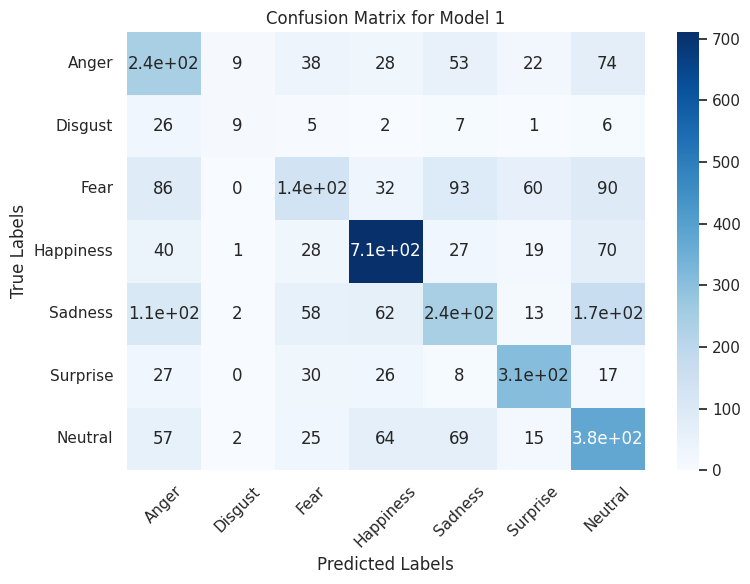

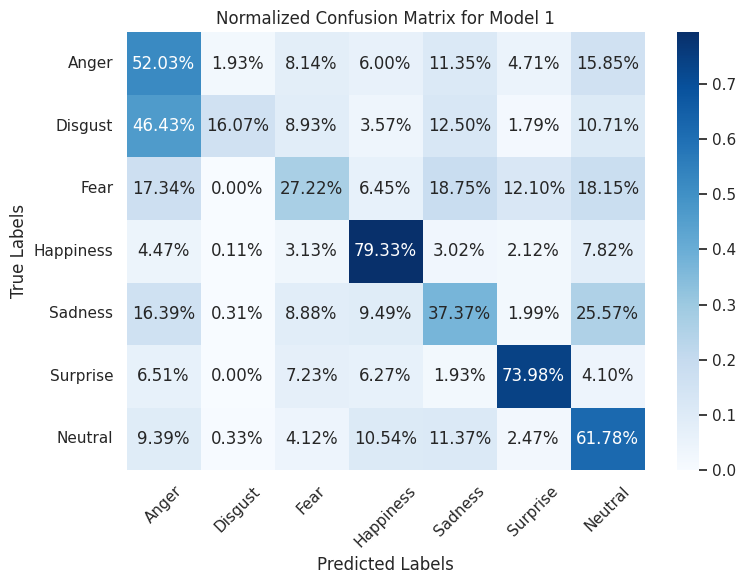

113/113 [==============================] - 1s 5ms/step
Classification Report for Model 2:
              precision    recall  f1-score   support

           0       0.55      0.60      0.57       467
           1       0.61      0.39      0.48        56
           2       0.52      0.27      0.36       496
           3       0.85      0.87      0.86       895
           4       0.55      0.52      0.54       653
           5       0.75      0.77      0.76       415
           6       0.52      0.71      0.60       607

    accuracy                           0.64      3589
   macro avg       0.62      0.59      0.59      3589
weighted avg       0.64      0.64      0.63      3589



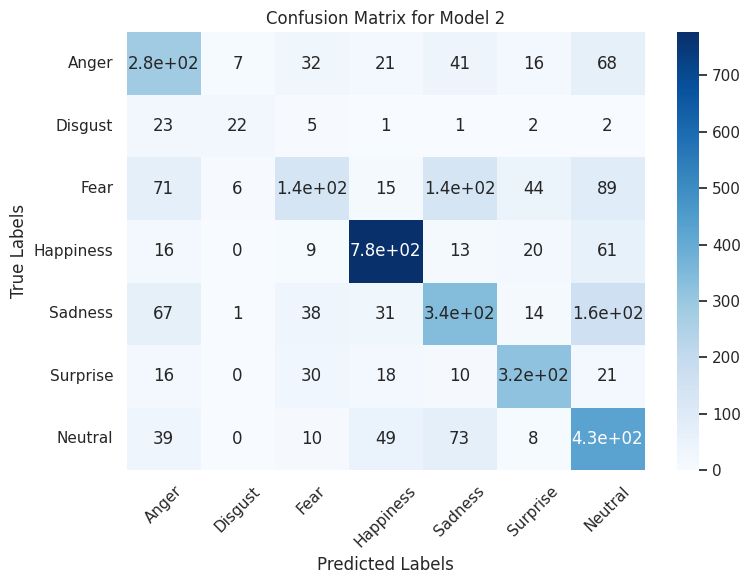

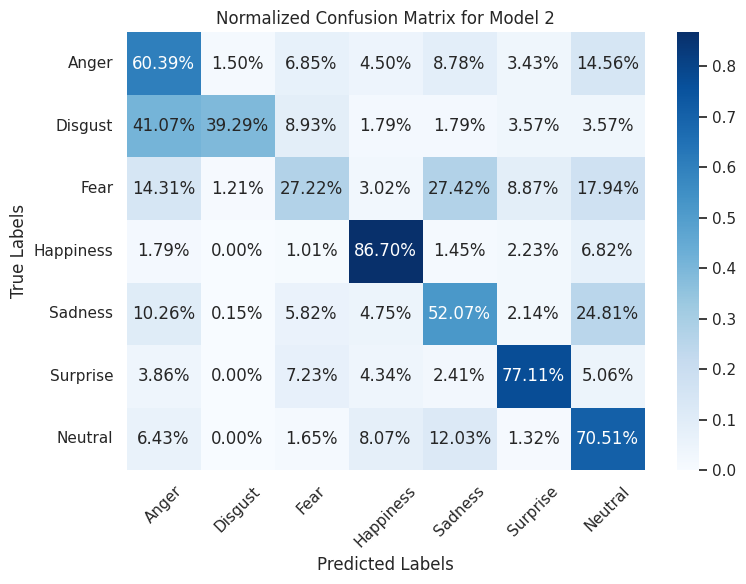

113/113 [==============================] - 0s 4ms/step
Classification Report for Model 3:
              precision    recall  f1-score   support

           0       0.57      0.59      0.58       467
           1       0.75      0.27      0.39        56
           2       0.59      0.20      0.30       496
           3       0.85      0.85      0.85       895
           4       0.52      0.51      0.52       653
           5       0.75      0.85      0.79       415
           6       0.49      0.74      0.59       607

    accuracy                           0.64      3589
   macro avg       0.65      0.57      0.58      3589
weighted avg       0.64      0.64      0.62      3589



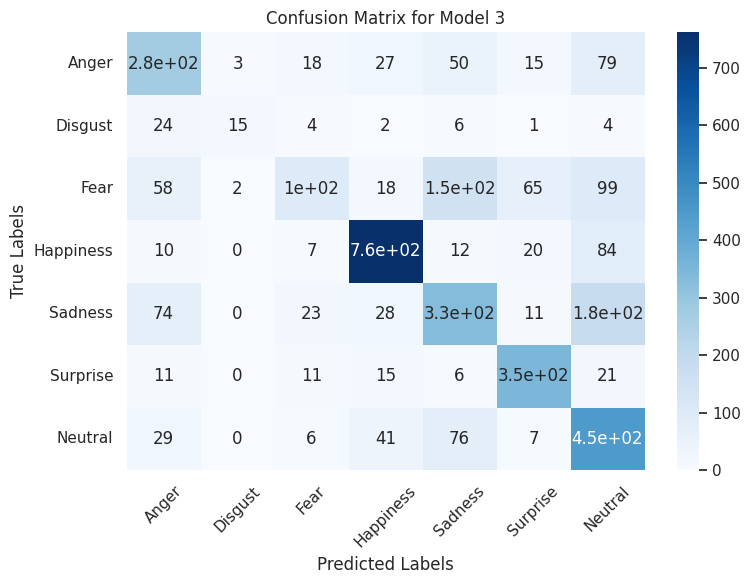

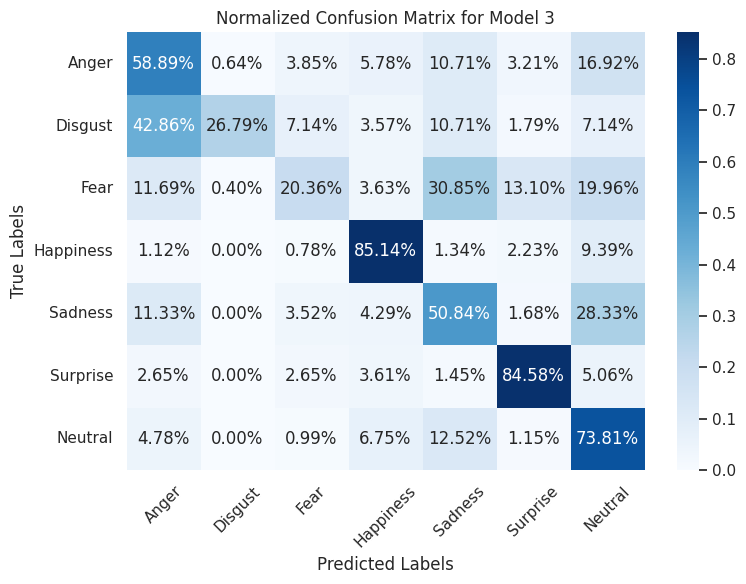

113/113 [==============================] - 1s 5ms/step
Classification Report for Model 4:
              precision    recall  f1-score   support

           0       0.52      0.38      0.44       467
           1       0.00      0.00      0.00        56
           2       0.33      0.14      0.20       496
           3       0.75      0.83      0.79       895
           4       0.43      0.49      0.46       653
           5       0.53      0.85      0.65       415
           6       0.48      0.51      0.49       607

    accuracy                           0.55      3589
   macro avg       0.43      0.46      0.43      3589
weighted avg       0.52      0.55      0.52      3589



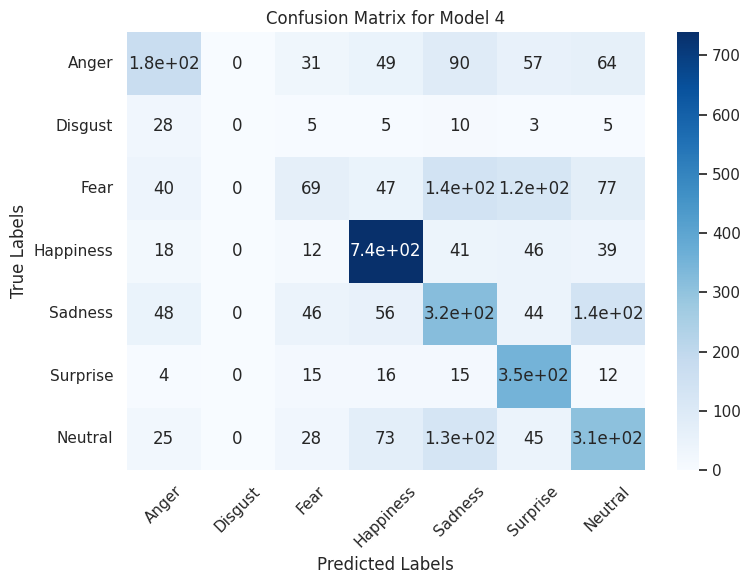

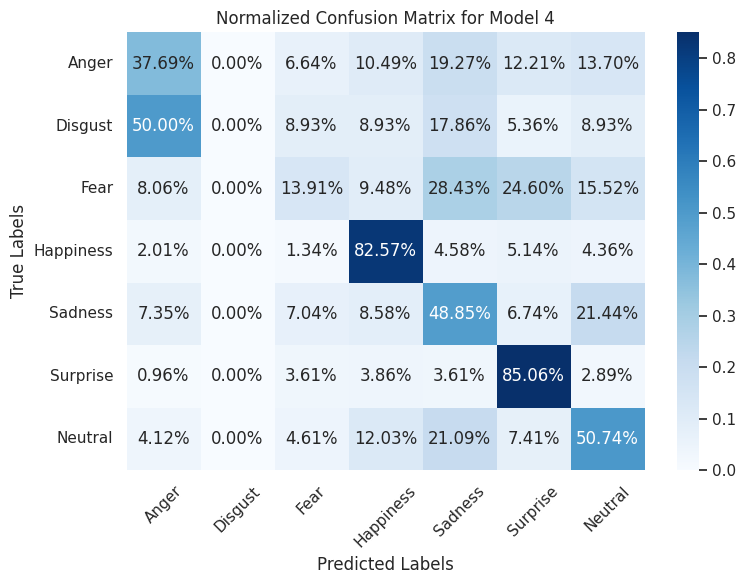

In [ ]:
for i, cnn in enumerate(cnns):
    predictions = cnn.predict(X_test)
    print(f"Classification Report for Model {i + 1}:")
    print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), zero_division=0))
    print("===========================================")

    # Calculate confusion matrix
    conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

    # Plotting the classic confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=classes_of_emotions.values(),
                yticklabels=classes_of_emotions.values())
    plt.title(f'Confusion Matrix for Model {i + 1}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(prediction_results_path + f'confusion_matrix_{i + 1}_classic.png')
    plt.show()
    plt.close()

    # Calculate normalized confusion matrix
    conf_mat_norm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), normalize='true')

    # Plotting the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat_norm, annot=True, fmt=".2%", cmap="Blues", xticklabels=classes_of_emotions.values(),
                yticklabels=classes_of_emotions.values())
    plt.title(f'Normalized Confusion Matrix for Model {i + 1}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(prediction_results_path + f'confusion_matrix_{i + 1}_normalized.png')
    plt.show()
    plt.close()


## **Training and Validation Performance Analysis**

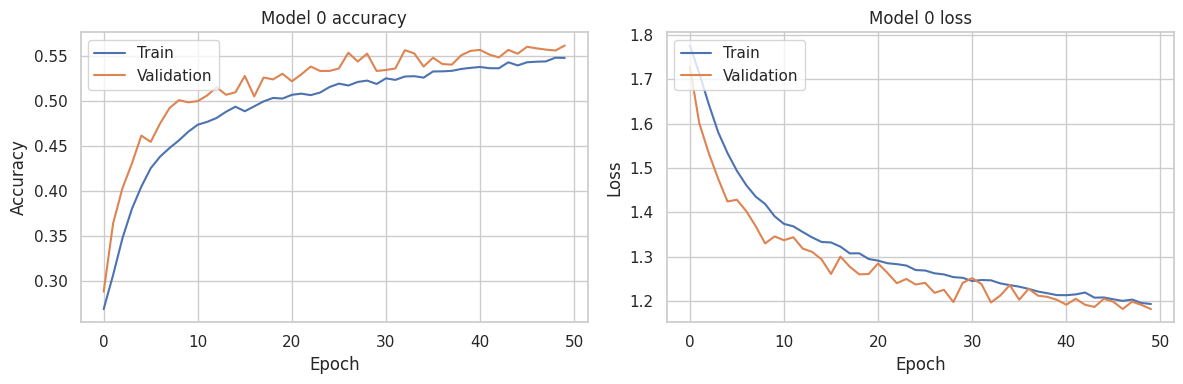

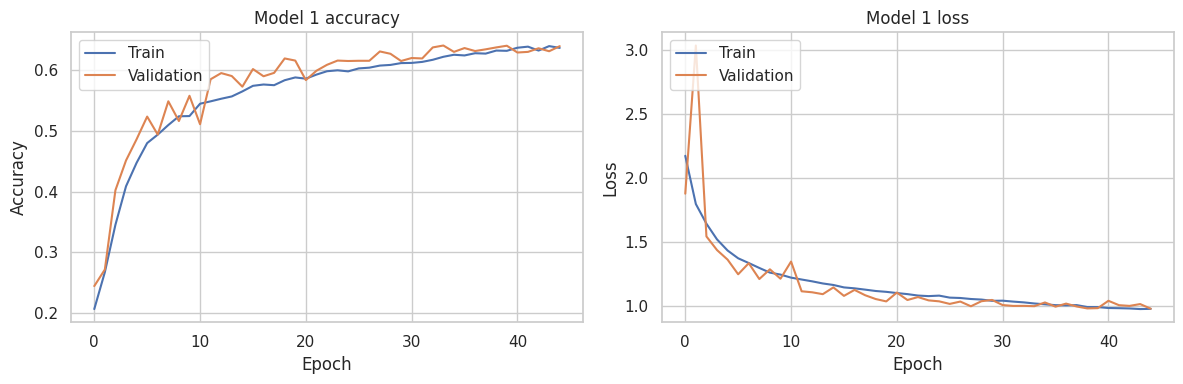

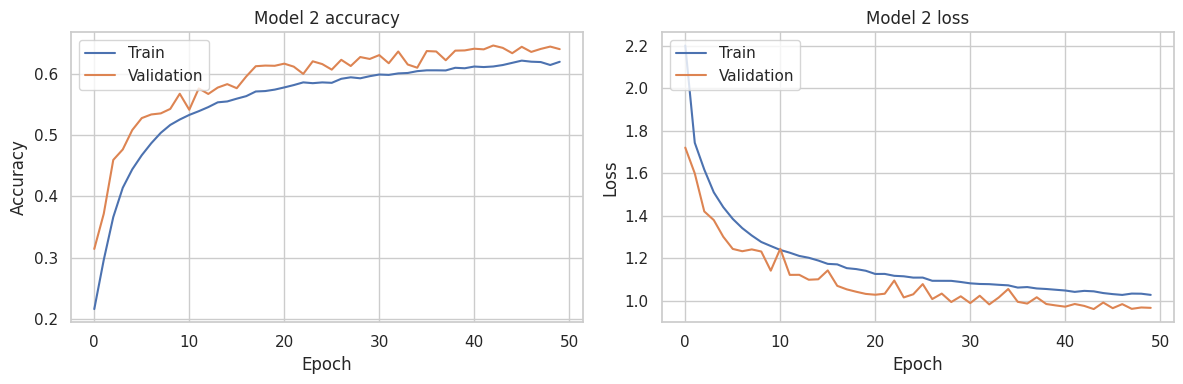

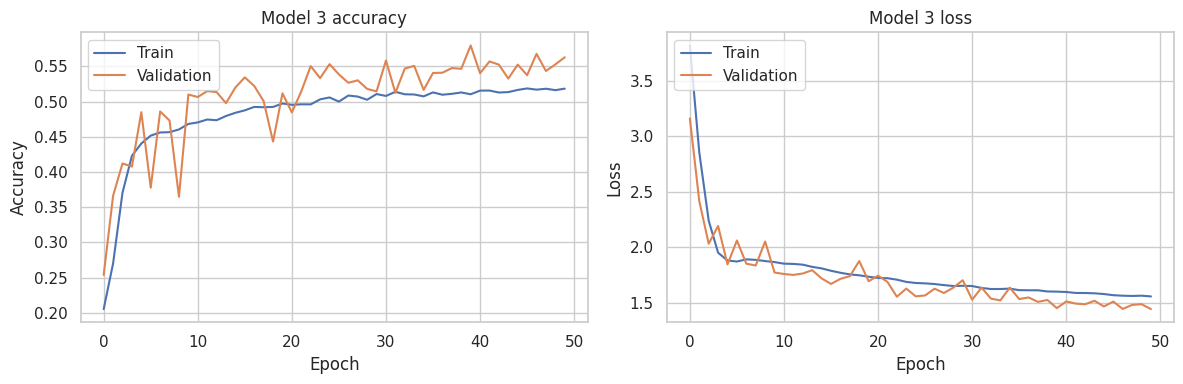

In [ ]:
for i, history in enumerate(histories):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title(f"Model {i} accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title(f"Model {i} loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    plt.tight_layout()
    plt.savefig(loss_accuracy_path + f"plot_cnn_model_{i+1}.png")
    plt.show()

    # Save in csv file
    csv_file_path = loss_accuracy_path + f"loss_accuracy_model_{i + 1}.csv"
    with open(csv_file_path, "w", newline="") as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['Epoch', 'Accuracy', 'Validation Accuracy', 'Loss', 'Validation Loss'])
        for epoch, acc, val_acc, loss, val_loss in zip(
            range(1, len(history.history["accuracy"]) + 1),
            history.history["accuracy"],
            history.history["val_accuracy"],
            history.history["loss"],
            history.history["val_loss"]
        ):
            writer.writerow([epoch, acc, val_acc, loss, val_loss])

## **Saving Model Architectures and Weights**

We can save the model architecture to a JSON file and the trained weights to an H5 file. Later, we can load the model architecture from the JSON file and load the trained weights from the H5 file to recreate and utilize the trained models for prediction or further analysis. This allows us to easily restore the models without the need to retrain them, enabling efficient use of the trained models for various tasks.

In [ ]:
h5_files = []
json_files = []

for i, cnn in enumerate(cnns):
    # Save cnn Architectures to .json
    fer2013_json = cnn.to_json()
    json_file_path = os.path.join(models_path, f"Model_{i + 1}_fer2013.json")
    with open(json_file_path, "w") as json_file:
        json_file.write(fer2013_json)
    json_files.append(json_file_path)

    # Save cnn Weights to .h5
    weights_file_path = os.path.join(models_path, f"Model_{i + 1}_fer2013.h5")
    cnn.save_weights(weights_file_path)
    h5_files.append(weights_file_path)

# Load Chosen Model

## **Selext Model**

Available Model Files

In [ ]:
h5_files = [f for f in os.listdir(models_path) if f.endswith(".h5")]
json_files = [f for f in os.listdir(models_path) if f.endswith(".json")]

Just a simple interaction with the user :)

In [ ]:
if len(h5_files) == 0 or len(json_files) == 0:
    print("No .h5 or .json files found in the directory.")
else:
    print("Available models:")
    for i, (h5_file, json_file) in enumerate(zip(h5_files, json_files)):
        print(f"{i+1}. {h5_file} / {json_file}")
    
    chosen_model_index = input("Enter the number of the model you want to load: ")
    chosen_model_index = int(chosen_model_index) - 1
    
    if chosen_model_index < 0 or chosen_model_index >= len(h5_files):
        print("Invalid model index.")
    else:
        h5_file_path = os.path.join(models_path, h5_files[chosen_model_index])
        json_file_path = os.path.join(models_path, json_files[chosen_model_index])

        # Load the model architecture from the JSON file
        with open(json_file_path, "r") as json_file:
            loaded_model_json = json_file.read()

        model = model_from_json(loaded_model_json)

        # Load the model weights from the .h5 file
        model.load_weights(h5_file_path)

        print("The model was Succesfully Loaded! :) ")

Available models:
1. Model_1_fer2013.h5 / Model_1:_fer2013.json
2. Model_2_fer2013.h5 / Model_2_fer2013.json
3. Model_3_fer2013.h5 / Model_4_fer2013.json
4. Model_4_fer2013.h5 / Model_3_fer2013.json
Enter the number of the model you want to load: 2
The model was Succesfully Loaded! :) 


## **Model Layers**

In [ ]:
for layer in model.layers:
    print(layer)
print(len(model.layers))    

26


## **Visualizing Convolutional Filters in Each Layer**

In [ ]:
for idx, layer in enumerate(model.layers):
    if isinstance(layer, keras.layers.Conv2D):
        layer_name = layer.name
        
        filters, _ = layer.get_weights()
        
        n_filters = filters.shape[3]
        
        fig = plt.figure(figsize=(18, 18))
        
        rows = int(np.sqrt(n_filters))
        cols = int(np.ceil(n_filters / rows))
        
        for i in range(n_filters):
            # Get the filter
            f = filters[:, :, :, i]
            
            ax = plt.subplot(rows, cols, i+1)
            ax.imshow(f[:, :, 0], cmap="gray")
            ax.axis("off")
        
        plt.suptitle(layer_name)
        
        position = str(idx + 1).zfill(2)
        
        filename = "Filters/" + f"layer_{position}_{layer_name}.png"
        save_path = os.path.join(layers_path, filename)
        plt.savefig(save_path)
        
        plt.close()

Listing Layer Names in the Model

In [ ]:
for layer in model.layers:
    print(layer.name)

conv2d_22
batch_normalization_24
conv2d_23
batch_normalization_25
max_pooling2d_13
dropout_15
conv2d_24
batch_normalization_26
conv2d_25
batch_normalization_27
max_pooling2d_14
dropout_16
conv2d_26
batch_normalization_28
conv2d_27
batch_normalization_29
max_pooling2d_15
dropout_17
flatten
dense_13
batch_normalization_30
dropout_18
dense_14
batch_normalization_31
dropout_19
dense_15


## **Visualization for Each Layer in the Model**

Random Image Selection from the Training Set

In [ ]:
example = X_train[np.random.randint(0, len(X_train))]

In [ ]:
for idx, layer in enumerate(model.layers):
    if isinstance(layer, keras.layers.Conv2D):
        layer_name = layer.name
        
        intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        
        intermediate_output = intermediate_layer_model.predict(example[np.newaxis, ...])
        
        if len(intermediate_output.shape) == 2:
            intermediate_output = np.expand_dims(intermediate_output, axis=-1)
        
        plt.figure(figsize=(18, 18))
        
        if len(intermediate_output.shape) == 4:
            num_subplots = intermediate_output.shape[-1]
            rows = int(np.sqrt(num_subplots))
            cols = int(np.ceil(num_subplots / rows))
        
            for i in range(num_subplots):
                plt.subplot(rows, cols, i+1)
                plt.imshow(intermediate_output[0, :, :, i], cmap="gray")
                plt.axis("off")
        elif len(intermediate_output.shape) == 2:
            plt.imshow(intermediate_output, cmap="gray")
            plt.axis("off")
        
        plt.suptitle(layer_name)
        
        position = str(idx + 1).zfill(2)
        
        filename = f"layer_{position}_{layer_name}.png"
        save_path = os.path.join(layers_path, filename)
        plt.savefig(save_path)
        
        plt.close()


1/1 [==============================] - 0s 105ms/step


# Try Chosen Model on Recorded video

Load all available videos

In [ ]:
# videos_path = main_directory_path + "backup/" 

In [ ]:
video_files = glob.glob(os.path.join(videos_path, "*.mp4"))

In [ ]:
video_files

In [ ]:
# model = model_from_json("loaded_model_json")
# model.load_weights("h5_file_path")

Use pre-trainerd face detection from cv2, CascadeClassifier

In [ ]:
# Load the cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

Select the number of frames you want to test the model.

In [ ]:
n = 1  # Process every chosen frame as n (roughly one per second for 30 FPS video)

for video_file in video_files:
    # Capture video from file
    cap = cv2.VideoCapture(video_file)

    frame_count = 0
    output_file = os.path.splitext(video_file)[0] + "_with_emotions.mp4"
    video_writer = None

    while True:
        # Read the frame
        ret, img = cap.read()

        if not ret:
            break

        # Process every nth frame
        if frame_count % n == 0:
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Detect the faces
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)

            for (x, y, w, h) in faces:
                # Extract the region of interest (face) and resize to the input shape of the model
                roi_gray = gray[y:y + h, x:x + w]
                roi_gray = cv2.resize(roi_gray, (48, 48))
                roi_gray = roi_gray / 255.0

                # Add a new dimension for the batch and predict the emotion
                roi_gray = np.expand_dims(roi_gray, axis=0)
                roi_gray = np.expand_dims(roi_gray, axis=-1)
                prediction = model.predict(roi_gray)

                # Get the predicted emotion class index
                emotion_class = np.argmax(prediction)

                # Get the predicted emotion label
                emotion_label = classes_of_emotions[emotion_class]

                # Draw bounding box and label on the image
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(img, "Emotion: " + emotion_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9,
                            (0, 255, 0), 2)

                # Write the frame with the prediction to the output video
                if video_writer is None:
                    frame_height, frame_width, _ = img.shape
                    video_writer = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*"mp4v"), 30,
                                                   (frame_width, frame_height))

                video_writer.write(img)

        frame_count += 1

    # Close the video file
    cap.release()

    # Release the video writer
    if video_writer is not None:
        video_writer.release()


1/1 [==============================] - 0s 24ms/step


The tested video

In [ ]:
video_files = glob.glob(os.path.join(videos_path, "*.mp4"))

In [ ]:
video_files

['./drive/MyDrive/Group_4/Data/Videos/video1.mp4',
 './drive/MyDrive/Group_4/Data/Videos/video2.mp4',
 './drive/MyDrive/Group_4/Data/Videos/video1_with_emotions.mp4',
 './drive/MyDrive/Group_4/Data/Videos/video2_with_emotions.mp4']

In [ ]:
video_path = video_files[2]
clip = VideoFileClip(video_path)

slow_clip = clip.fx(vfx.speedx, 0.2)  # Create slow-motion clip with a speed factor of 0.5

# Specify the desired maximum width or height for the small size
max_width = 320
max_height = 400

# Calculate the new width and height while maintaining the aspect ratio
if clip.size[0] > clip.size[1]:
    # Landscape orientation
    desired_width = max_width
    desired_height = int(clip.size[1] * max_width / clip.size[0])
else:
    # Portrait or square orientation
    desired_height = max_height
    desired_width = int(clip.size[0] * max_height / clip.size[1])

# Save the clip to a temporary file
temp_file = tempfile.NamedTemporaryFile(suffix='.mp4')
slow_clip.write_videofile(temp_file.name, codec='libx264')

# Create an HTML video widget to display the video
video_widget = widgets.Video.from_file(temp_file.name,
                                       width=desired_width,
                                       height=desired_height,
                                       loop=True,
                                       autoplay=True)

# Display the video widget
display(video_widget)

Moviepy - Building video /tmp/tmpeid20qh_.mp4.
Moviepy - Writing video /tmp/tmpeid20qh_.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpeid20qh_.mp4


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x10e\xe5mdat\x00\x…

# Compare chosen model with VGG16 with VGG MODEL

In [ ]:
# Load the pre-trained VGG16 model without the top layers
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(48, 48, 3))

# Duplicate the grayscale channel 3 times
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Create a new model
model_vgg = Sequential()

# Add the VGG16 base model to the new model
model_vgg.add(base_model)

# Add custom layers on top of the VGG16 base model
model_vgg.add(GlobalAveragePooling2D())
model_vgg.add(Dense(1024, activation="relu"))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(7, activation="softmax"))  # Output layer with 7 classes for the Fer2013 dataset

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_vgg.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

batch_size = 32
steps_per_epoch = len(X_train) / 32
epochs = 50
train_batches = gen.flow(X_train_rgb, y_train, batch_size=batch_size)

# Train the model
history = model_vgg.fit(
    train_batches,
    validation_data = (X_val_rgb, y_val),
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    callbacks = callbacks,
    use_multiprocessing = True
    )

# Evaluate the model
y_pred = model_vgg.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test.argmax(axis=1), y_pred_classes))

58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/50
807/807 [==============================] - 65s 68ms/step - loss: 1.7177 - accuracy: 0.3150 - val_loss: 1.6542 - val_accuracy: 0.3525
Epoch 2/50
807/807 [==============================] - 52s 65ms/step - loss: 1.6623 - accuracy: 0.3396 - val_loss: 1.5989 - val_accuracy: 0.3779
Epoch 3/50
807/807 [==============================] - 50s 62ms/step - loss: 1.6503 - accuracy: 0.3465 - val_loss: 1.5895 - val_accuracy: 0.3797
Epoch 4/50
807/807 [==============================] - 52s 64ms/step - loss: 1.6369 - accuracy: 0.3519 - val_loss: 1.5858 - val_accuracy: 0.3779
Epoch 5/50
807/807 [==============================] - 51s 64ms/step - loss: 1.6377 - accuracy: 0.3535 - val_loss: 1.5751 - val_accuracy: 0.3936
Epoch 6/50
807/807 [==============================] - 53s 66ms/step - loss: 1.6235 - accuracy: 0.3566 - val_loss: 1.5632 - val_accuracy: 0.3999
Epoch 7/50
807/807 [==============================] - 52s 65ms/step - l

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))



              precision    recall  f1-score   support

           0       0.37      0.21      0.27       467
           1       0.00      0.00      0.00        56
           2       0.30      0.15      0.20       496
           3       0.42      0.72      0.53       895
           4       0.38      0.32      0.35       653
           5       0.60      0.51      0.55       415
           6       0.38      0.39      0.38       607

    accuracy                           0.41      3589
   macro avg       0.35      0.33      0.33      3589
weighted avg       0.40      0.41      0.39      3589



In [ ]:
predictions = model_vgg.predict(X_test_rgb )
print("0 attempt: \n",classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)))


113/113 [==============================] - 1s 12ms/step


  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))



0 attempt: 
               precision    recall  f1-score   support

           0       0.37      0.21      0.27       467
           1       0.00      0.00      0.00        56
           2       0.30      0.15      0.20       496
           3       0.42      0.72      0.53       895
           4       0.38      0.32      0.35       653
           5       0.60      0.51      0.55       415
           6       0.38      0.39      0.38       607

    accuracy                           0.41      3589
   macro avg       0.35      0.33      0.33      3589
weighted avg       0.40      0.41      0.39      3589



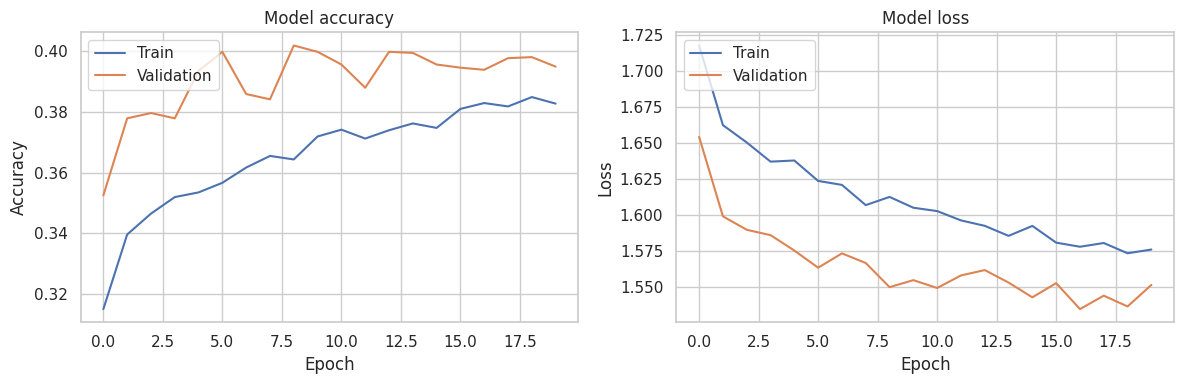

In [ ]:

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()